# ECON 470 Homework 4-1
##### Ellen Wu

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from tabulate import tabulate
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

1. Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits). Provide a box and whisker plot showing the distribution of plan counts by county over time. Do you think that the number of plans is sufficient, too few, or too many?

In [2]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

In [4]:
print(cleaned.columns.tolist())

['contractid', 'planid', 'org_type', 'plan_type', 'partd', 'snp', 'eghp', 'org_name', 'org_marketing_name', 'plan_name', 'parent_org', 'contract_date', 'ssa', 'fips', 'state', 'county', 'avg_enrollment', 'year', 'breastcancer_screen', 'rectalcancer_screen', 'cv_cholscreen', 'diabetes_cholscreen', 'glaucoma_test', 'monitoring', 'flu_vaccine', 'pn_vaccine', 'primaryaccess', 'hospital_followup', 'depression_followup', 'nodelays', 'carequickly', 'overallrating_care', 'overallrating_plan', 'calltime', 'doctor_communicate', 'osteo_manage', 'diabetes_eye', 'diabetes_kidney', 'diabetes_bloodsugar', 'diabetes_chol', 'antidepressant', 'bloodpressure', 'ra_manage', 'copd_test', 'betablocker', 'appeals_timely', 'appeals_review', 'new_contract', 'physical_health', 'mental_health', 'osteo_test', 'physical_monitor', 'customer_service', 'bladder', 'falling', 'partc_score', 'cv_diab_cholscreen', 'diab_healthy', 'complaints_plan', 'leave_plan', 'audit_problems', 'hold_times', 'info_accuracy', 'ttyt_avai

In [ ]:
cleaned = df.copy()

#Remove Special Needs Plans (SNPs)
cleaned = cleaned[cleaned["snp"] != "Yes"]

#Remove 800-series plans (planid starts with 800)
cleaned = cleaned[~cleaned["planid"].astype(str).str.startswith("800")]

#Remove prescription drug only plans (i.e., keep only those that offer Part C)
# Usually plan_type == 'PDP' means drug-only, so remove those
cleaned = cleaned[cleaned["plan_type"] != "PDP"]

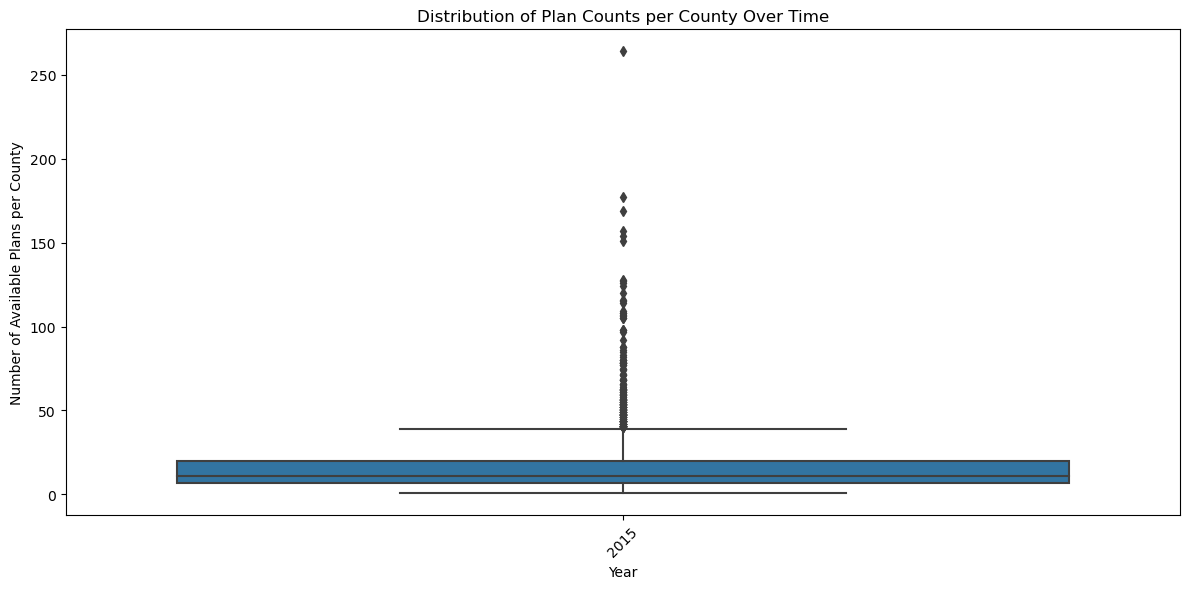

In [6]:
# Group by county and year to count plans
county_plan_counts = (
    cleaned.groupby(["state", "county", "year"])
    .size()
    .reset_index(name="plan_count")
)

# Box and whisker plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=county_plan_counts, x="year", y="plan_count")

plt.title("Distribution of Plan Counts per County Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Available Plans per County")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
print(cleaned["year"].value_counts().sort_index())

2015    49408
Name: year, dtype: int64


In [9]:
# Step-by-step filter check with year breakdown
cleaned = df.copy()
print("🔹 Before any filtering:")
print(cleaned["year"].value_counts().sort_index())

# 1. Remove SNPs
cleaned = cleaned[cleaned["snp"] != "Yes"]
print("\n🔹 After removing SNPs:")
print(cleaned["year"].value_counts().sort_index())

# 2. Remove 800-series plans
cleaned = cleaned[~cleaned["planid"].astype(str).str.startswith("800")]
print("\n🔹 After removing 800-series plans:")
print(cleaned["year"].value_counts().sort_index())

# 3. Remove Part D-only plans (PDP)
print("\n🧪 plan_type value counts before removing PDP:")
print(cleaned["plan_type"].value_counts(dropna=False))  # this is key

cleaned = cleaned[cleaned["plan_type"] != "PDP"]
print("\n🔹 After removing PDPs:")
print(cleaned["year"].value_counts().sort_index())

🔹 Before any filtering:
2015    49408
Name: year, dtype: int64

🔹 After removing SNPs:
2015    49408
Name: year, dtype: int64

🔹 After removing 800-series plans:
2015    49408
Name: year, dtype: int64

🧪 plan_type value counts before removing PDP:
HMO/HMOPOS                           17919
Local PPO                            14235
Regional PPO                          7389
1876 Cost                             4907
PFFS                                  3181
Medicare-Medicaid Plan HMO/HMOPOS      865
National PACE                          690
MSA                                    222
Name: plan_type, dtype: int64

🔹 After removing PDPs:
2015    49408
Name: year, dtype: int64


In [10]:
# Check this part of your code
for y in range(2007, 2016):
    # at the end of each loop
    if y == 2007:
        final_data = ma_macd_data  # or plan_premiums
    else:
        final_data = pd.concat([final_data, ma_macd_data], ignore_index=True)

NameError: name 'ma_macd_data' is not defined

2. Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

In [11]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

# Filter for the years of interest
years_to_plot = [2010, 2012, 2015]
ratings_subset = df[
    (df["year"].isin(years_to_plot)) & (df["Star_Rating"].notna())
]

⚠️ No data for year 2012


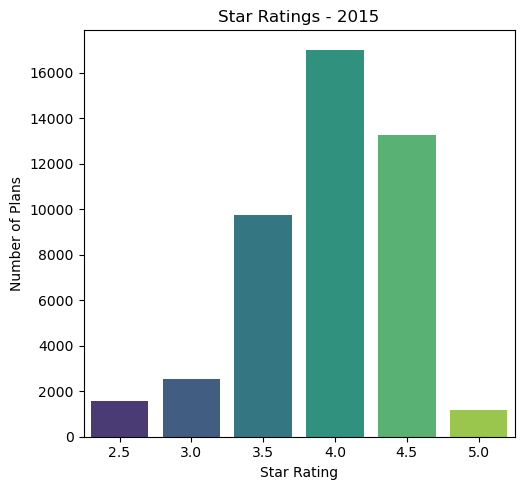

In [18]:
plt.figure(figsize=(15, 5))

for i, year in enumerate(years_to_plot):
    data_year = ratings_subset[ratings_subset["year"] == year]
    
    if data_year.empty:
        print(f"⚠️ No data for year {year}")
        continue
    
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=data_year, x="Star_Rating", palette="viridis")
    plt.title(f"Star Ratings - {year}")
    plt.xlabel("Star Rating")
    plt.ylabel("Number of Plans")

plt.tight_layout()
plt.show()

3. Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

In [20]:
df= pd.read_csv("/Users/ellenwu/homework4/data/output/final_ma_data.csv")

# Filter for years 2010–2015
bench_2010_2015 = df[
    (df["year"].between(2010, 2015)) & 
    (df["ma_rate"].notna())
]

# Group by year and calculate the average benchmark
avg_benchmark = (
    bench_2010_2015.groupby("year")["ma_rate"]
    .mean()
    .reset_index()
)

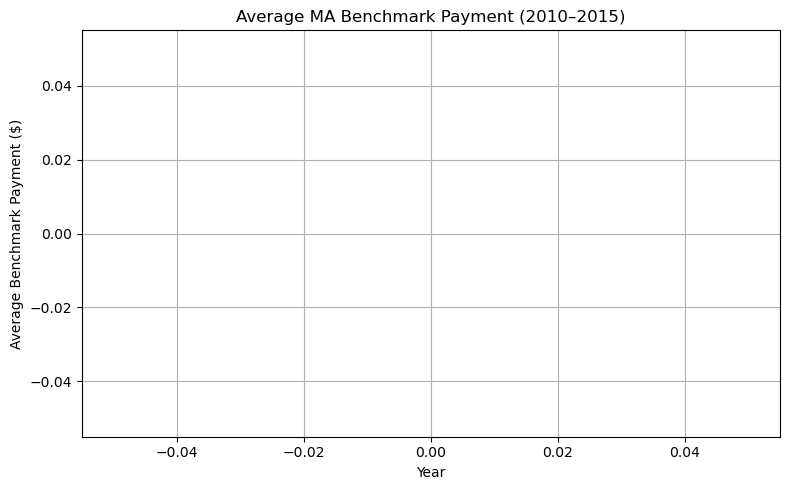

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(avg_benchmark["year"], avg_benchmark["ma_rate"], marker='o', linestyle='-')
plt.title("Average MA Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
rate_2010 = avg_benchmark[avg_benchmark["year"] == 2010]["ma_rate"].values[0]
rate_2015 = avg_benchmark[avg_benchmark["year"] == 2015]["ma_rate"].values[0]
change = rate_2015 - rate_2010
percent_change = (change / rate_2010) * 100

print(f"Average benchmark payment increased by ${change:.2f}, or {percent_change:.2f}%, from 2010 to 2015.")

IndexError: index 0 is out of bounds for axis 0 with size 0